## COMP3670/6670 Programming Assignment 2 - Clustering and Regularization
---

**Enter Your Student ID: u7689173**

**Your Name: Aryan Odugoudar**
    
**Deadline:** 

**Submit:** Write your answers in this file, and submit a single Jupyter Notebook file (.ipynb) on Wattle. Rename this file with your student number as 'uXXXXXXX.ipynb'. Note: you don't need to submit the .png or .npy files. 

**Enter Discussion Partner IDs Below:**
You could add more IDs with the same markdown format above.

**Programming Section**:
- Tasks 1.1 - 1.4: 30%
- Task 1.5-1.7: 30%
- Task 2: 40%

In [1]:
import time
import sys
! pip install numpy
import numpy as np
! pip install matplotlib
import matplotlib.pyplot as plt
import math
import os
from matplotlib.pyplot import imread
! pip install patchify
from patchify import patchify
import math as m

np.random.seed(1)


## Task 1: Clustering
-----------
These programming exercises will focus on K-means clustering. 

If you're unsure of how K-Means works, read this very helpful and freely available online breakdown from Stanford's CS221 course; https://stanford.edu/~cpiech/cs221/handouts/kmeans.html

This assignment requires you to loosely interpret how K-Means is a specific case of a more general algorithm named Expectation Maximisation. This is explained toward the end of the above article.

First, let us load the dataset we'll be using throughout Task 1.

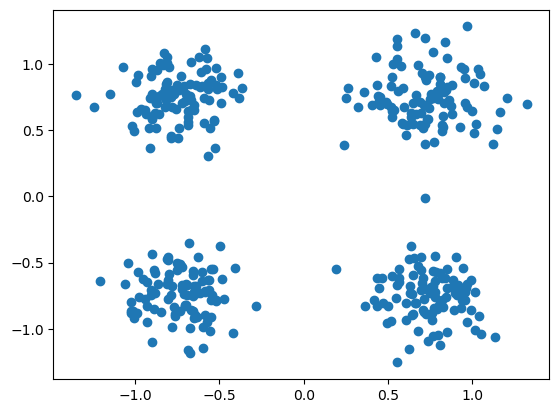

In [2]:
X = np.load("./data_clustering.npy")
plt.scatter(X[:,0], X[:,1])
plt.show()

K-Means is a special, simple case of the Expectation Maximisation (EM) algorithm.

This simplified EM (K-Means), is divided into two steps.

We refer to a cluster representative as the "centroid".

The **E-Step**, where for every datapoint in your dataset, you find which "centroid" is closest to it, and record that information.

The **M-Step**, where you move each "centroid" to the center of the samples which were found to be closest to it in the **E-Step**.

Each *centroid* is simply an estimated mean of a cluster. If you have $1$ centroid, then this centroid will become the mean of all your data.

Centroids are initially random values, and the K-Means algorithm attempts to modify them so that each one represents the center of a cluster.

We have implemented a centroids initialization function.

In [3]:
def initialise_parameters(m, X):
    C = X[np.random.choice(X.shape[0], m)]
    return C

C = initialise_parameters(4, X)
print(C)

[[ 0.55638768  1.19083041]
 [ 0.99468733 -0.63105385]
 [-0.80861347 -0.47487527]
 [ 0.83443335  0.7038998 ]]


Now let's implement the K-Means algorithm.

---
   **TASK 1.1:** Create a function $E\_step(C, X) = L$, where $L$ is a matrix of the same dimension of the dataset $X$.
   
   This function is is the **E-Step** (or "assignment step") mentioned earlier.

---

**HINT:** 
- https://stanford.edu/~cpiech/cs221/handouts/kmeans.html
- https://en.wikipedia.org/wiki/K-means_clustering#Standard_algorithm
- Each row of $L$ is a centroid taken from $C$.

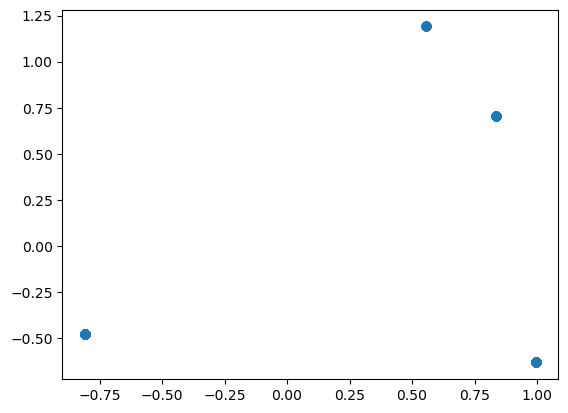

In [4]:
def E_step(C, X):
    L = np.zeros(X.shape)  # initialize L based on the shape of X
    for i in range(X.shape[0]):
        min_dist = np.Inf
        min_dist_idx = None
        for j in range(C.shape[0]):
            dist = euclidean_dist(X[i], C[j])  # euclidean distance between sample x and centroid c
            if dist < min_dist:
                min_dist = dist   # update minimum distance
                min_dist_idx = j  # update index of centroid
        L[i] = C[min_dist_idx]    # update centroid
    return L


def euclidean_dist(x_1, x_2):
    """ Computing Eudlidean distance between two vectors.
    Euclidean distance is defined as bellow:
    dist(x, y) = sqrt(sum((x_i - y_i)^2)), where i range [1, n],
    n is the dimension of x and y.
    
    Params:
        x_1(iterable object): a 1-D vector 
        x_2(iterable object): a 1-D vector
        
    Returns:
        Eudlidean distance between x_1 and x_2
    """
    x_1 = np.array(x_1).reshape(-1)
    x_2 = np.array(x_2).reshape(-1)
    return sum(map(lambda diff: diff ** 2, x_1 - x_2)) ** (1 / 2)

    
L = E_step(C, X)
plt.scatter(L[:, 0], L[:, 1])
plt.show()

---
**TASK 1.2:** Create a function $M\_step(C, X, L) = C$ which returns $C$ modified so that each centroid in $C$ is placed in the middle of the samples assigned to it. This is the **M-Step**.

In other words, make each centroid in $C$ the average of all the samples which were found to be closest to it during the **E-step**. This is also called the "update step" for K-Means.

---

**HINT:** https://docs.scipy.org/doc/numpy/reference/generated/numpy.array_equal.html

In [5]:
def M_step(C, X, L):
    
    # X_idx[i] represents index of samples that are closest to centroid i
    X_idx = [[] for _ in range(C.shape[0])]
    
    for i in range(X.shape[0]):  # find centroid index of each sample
        centroid_idx = np.where(np.all(C == L[i], axis=1))[0][0]
        X_idx[centroid_idx].append(i)

    for i in range(C.shape[0]):  # compute new centroids
        C[i] = X[X_idx[i]].mean(axis=0)
    
    return C

print('Before:')
print(C)
print('\nAfter:')
new_C = M_step(C, X, L)
print(new_C)

Before:
[[ 0.55638768  1.19083041]
 [ 0.99468733 -0.63105385]
 [-0.80861347 -0.47487527]
 [ 0.83443335  0.7038998 ]]

After:
[[-0.18550673  0.94593855]
 [ 0.74859936 -0.74619961]
 [-0.76830416 -0.16807746]
 [ 0.75645564  0.69249107]]


---
**TASK 1.3:** Implement $kmeans(X, m, threshold) = C, L$ which takes a dataset $X$ (of any dimension) and a scalar value $m$ and a scalar $threshold$ as input. This function uses the previous 3 functions to:
- generate $m$ centroids.
- iterate between the E and M steps until the difference of loss values between two iterations is less than the threshold to classify the $m$ clusters.

...and then returns:
- $C$, the centers of the $m$ clusters after convergence.
- $L$, the labels (centroid vectors) assigned to each sample in the dataset after convergence.
---
**HINT:** Using initialise_parameters to initial centroid

Initial Parameters:
[[-0.18550673  0.94593855]
 [ 0.74859936 -0.74619961]
 [-0.76830416 -0.16807746]
 [ 0.75645564  0.69249107]]

Final Parameters:
[[ 0.72539561  0.75302836]
 [-0.73312486 -0.73655558]
 [ 0.74859936 -0.74619961]
 [-0.74965351  0.7531092 ]]


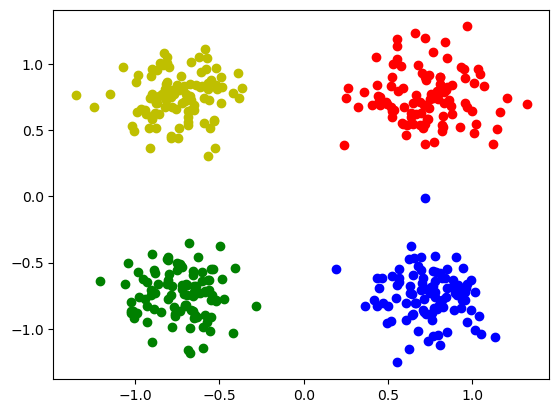

In [6]:
def kmeans(X, m, threshold):
    X = np.array(X)
    C = initialise_parameters(m, X)
    loss_before = np.Inf
    while True:
        L = E_step(C, X)
        loss = training_loss(X, L)
        if abs(loss_before - loss) < threshold:
            break
        C = M_step(C, X, L)
        loss_before = loss
    return C, L
    

def training_loss(X, L):
    return sum([euclidean_dist(X[i], L[i]) for i in range(X.shape[0])])


#CODE TO DISPLAY YOUR RESULTS. DO NOT MODIFY.
C_final, L_final = kmeans(X, 4, 1e-6)
print('Initial Parameters:')
print(C)
print('\nFinal Parameters:')
print(C_final)

def allocator(X, L, c):
    cluster = []
    for i in range(L.shape[0]):
        if np.array_equal(L[i, :], c):
            cluster.append(X[i, :])
    return np.asarray(cluster)

colours = ['r', 'g', 'b', 'y']
for i in range(4):
    cluster = allocator(X, L_final, C_final[i, :])
    plt.scatter(cluster[:,0], cluster[:,1], c=colours[i])
plt.show()

Your answer should like this, maybe with different colors:
![image](./cluster.png)

---
**Task 1.4:**
Implement a function `add_noise` to explore how the results of your clustering method change when you add Gaussian noise to your data.
This function will take two parameters, your dataset $X$, and the noise level you want to add.

Investigate how adding noise affects the robustness of your K-Means clustering by visually inspecting the results you get after applying K-means to the noisy data.

---

**Hint:** You can use the function np.random.normal to add noise.

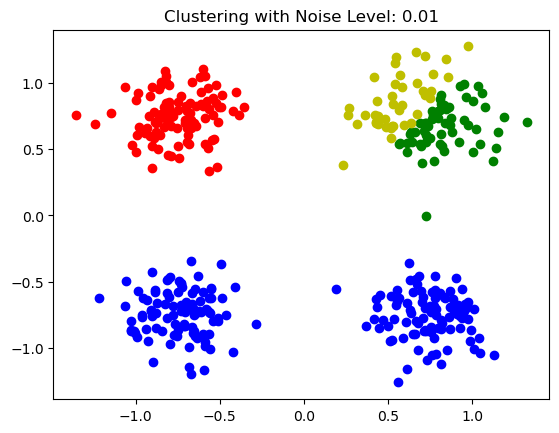

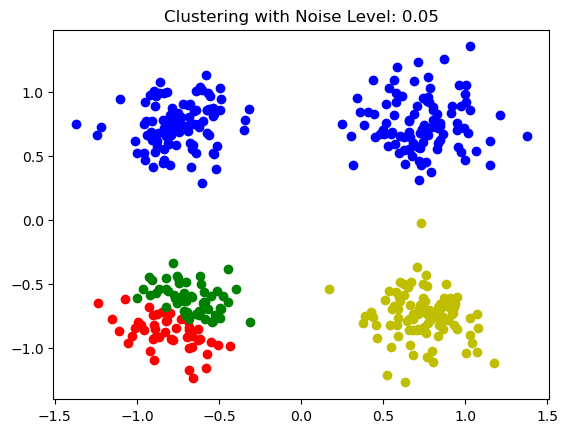

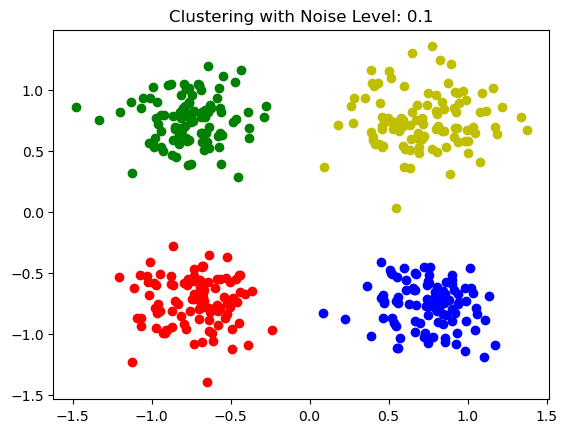

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def add_noise(X, noise_level):
    noisy_data = X + np.random.normal(0, noise_level, X.shape)
    return noisy_data

def allocator(X, L, c):
    cluster = []
    for i in range(L.shape[0]):
        if np.array_equal(L[i, :], c):
            cluster.append(X[i, :])
    return np.asarray(cluster)

def kmeans(X, m, threshold):
    X = np.array(X)
    C = initialise_parameters(m, X)
    loss_before = np.Inf
    while True:
        L = E_step(C, X)
        loss = training_loss(X, L)
        if abs(loss_before - loss) < threshold:
            break
        C = M_step(C, X, L)
        loss_before = loss
    return C, L

def training_loss(X, L):
    return sum([euclidean_dist(X[i], L[i]) for i in range(X.shape[0])])

def initialise_parameters(m, X):
    C = X[np.random.choice(X.shape[0], m)]
    return C

def E_step(C, X):
    L = np.zeros(X.shape)  
    for i in range(X.shape[0]):
        min_dist = np.Inf
        min_dist_idx = None
        for j in range(C.shape[0]):
            dist = euclidean_dist(X[i], C[j])
            if dist < min_dist:
                min_dist = dist
                min_dist_idx = j
        L[i] = C[min_dist_idx]
    return L

def M_step(C, X, L):
    X_idx = [[] for _ in range(C.shape[0])]
    for i in range(X.shape[0]):
        centroid_idx = np.where(np.all(C == L[i], axis=1))[0][0]
        X_idx[centroid_idx].append(i)

    for i in range(C.shape[0]):
        C[i] = X[X_idx[i]].mean(axis=0)
    
    return C

def euclidean_dist(x_1, x_2):
    x_1 = np.array(x_1).reshape(-1)
    x_2 = np.array(x_2).reshape(-1)
    return sum(map(lambda diff: diff ** 2, x_1 - x_2)) ** (1 / 2)

# Load the dataset
X = np.load("./data_clustering.npy")

# Running K-Means with different noise levels
noise_levels = [0.01, 0.05, 0.1]
for noise_level in noise_levels:
    noisy_data = add_noise(X, noise_level)
    C_final, L_final = kmeans(noisy_data, 4, 1e-6)

    colours = ['r', 'g', 'b', 'y']
    for i in range(4):
        cluster = allocator(noisy_data, L_final, C_final[i, :])
        plt.scatter(cluster[:, 0], cluster[:, 1], c=colours[i])
    plt.title(f'Clustering with Noise Level: {noise_level}')
    plt.show()


---
**Task 1.5:**
Friends-of-Friends (FoF) Algorithm

 In this task, you will implement and apply the Friends-of-Friends (FoF) clustering algorithm to identify clusters in your dataset $X$. 
 
 FoF is used to identify groups of particles in cosmological simulations that describe how the Universe evolves. For example, you can have a look at the incredible IllustrisTNG simulations https://www.tng-project.org/media/. The videos show the hierarchical structure formation in a simulated Universe.

 Implementation details:
 
The goal of the FoF algorithm is to identify clusters of objects that are closer to each other than a specified distance threshold.

If two objects are closer to each other than a given distance (called the linking length and denoted by $b$), they are considered "friends." If object A is friends with object B, and object B is friends with object C, then A, B, and C are all part of the same cluster.

General algorithm steps:
1. **Initialization**: Initialise a set of points.
2. **Linking Length Definition**: Select a distance, $b$, to be the criterion for connecting entities. 
3. **Clustering**:

   a. **Connection Analysis**: Determine connections between entities within distance $b$. If the distance between entitities A and B is less than $b$, then A and B are connected.
   
   b. **Group Formation**: Form or join groups based on connections; merge groups if necessary. 

4. **Completion**: Finalize groups; unconnected entities may be disregarded.



 ---

 **Hint**: You can use the  distance_matrix from scipy.spatial to compute the distances between the datapoints.

In [8]:
#example showing how to use the distance_matrix function
from scipy.spatial import distance_matrix

#The distance matrix is a matrix containing the Euclidean distances between all pairs of points of a given set of points.
arr1 = np.array([[1, 1], [2, 4]])
arr2 = np.array([[3, 2], [1, 4]])

dist_matrix = distance_matrix(arr1, arr2)
dist_matrix

array([[2.23606798, 3.        ],
       [2.23606798, 1.        ]])

In [27]:
import numpy as np
from scipy.spatial import distance_matrix
from scipy.sparse.csgraph import connected_components

def fof_clustering(X, b):
    # Calculate the distance matrix
    dist_matrix = distance_matrix(X, X)

    # Create an adjacency matrix based on the distance matrix
    adjacency_matrix = dist_matrix < b

    # Find connected components using the adjacency matrix
    n_components, labels = connected_components(adjacency_matrix)

    # Initialize clusters as empty lists
    clusters = [[] for _ in range(n_components)]

    # Assign points to clusters based on labels
    for i, label in enumerate(labels):
        clusters[label].append(i)

    # Remove empty clusters
    clusters = [cluster for cluster in clusters if cluster]

    return clusters

# Example usage
b = 0.4
clusters_fof = fof_clustering(X, b)
print("Number of clusters found:", len(clusters_fof))


Number of clusters found: 4


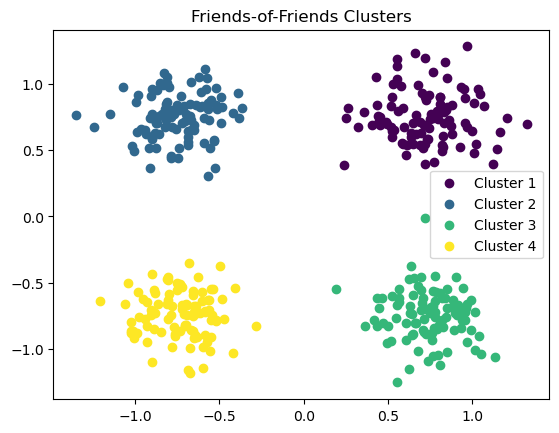

In [10]:
#Plot your FoF clustering results here

colors = plt.cm.get_cmap('viridis', len(clusters_fof))

for i, cluster in enumerate(clusters_fof):
    plt.scatter(X[cluster, 0], X[cluster, 1], color=colors(i), label=f'Cluster {i+1}')

plt.title('Friends-of-Friends Clusters')
plt.legend()
plt.show()

---
**TASK 1.6:** 
The Within-Cluster-Sum-of-Squares (WCSS) is defined as:

$$\text{WCSS} = \sum_{k=1}^{K} \sum_{i \in C_k} \left\| \mathbf{x}_i - \mathbf{c}_k \right\|^2$$

Create a function `wcss` which takes as input the data and the clusters and computes the total within-cluster sum of square.

---



In [11]:
def wcss(X, clusters):
    total_wcss = 0
    
    for cluster in clusters:
        cluster_center = np.mean(X[cluster], axis=0)  # Calculate the center of the cluster
        cluster_wcss = np.sum(np.linalg.norm(X[cluster] - cluster_center, axis=1) ** 2)  # Calculate WCSS for the cluster
        total_wcss += cluster_wcss
    
    return total_wcss

clusters = fof_clustering(X, b)

total_wcss = wcss(X, clusters)
print("Total WCSS:", total_wcss)


Total WCSS: 26.724594655127845


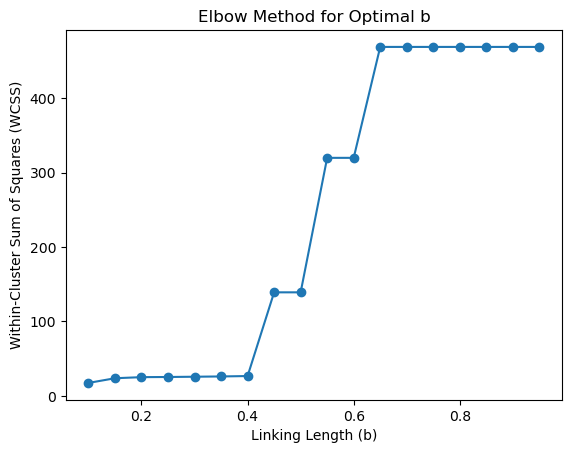

In [12]:
#Investigate what value of b is best.
b_values = np.arange(0.1, 1, 0.05)
wcss_values = [wcss(X, fof_clustering(X, b)) for b in b_values]

plt.plot(b_values, wcss_values, marker='o')
plt.xlabel('Linking Length (b)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal b')
plt.show()


---
**TASK 1.7:**  
Compare the robustness of the FoF (Friends-of-Friends) algorithm on the dataset X by investigating how the WCSS (within-cluster sum of squares) changes depending on the level of noise added to the data.


---

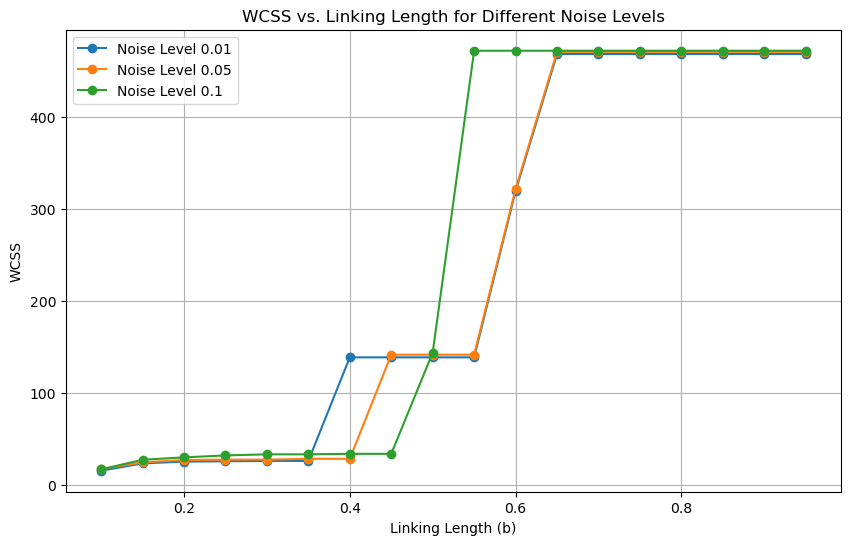

In [13]:
# Define noise levels and b values
noise_levels = [0.01, 0.05, 0.1]
b_values = np.arange(0.1, 1, 0.05)

# Store the WCSS values for different noise levels and b values
wcss_results = []

for noise_level in noise_levels:
    noisy_data = add_noise(X, noise_level)
    wcss_values = [wcss(noisy_data, fof_clustering(noisy_data, b)) for b in b_values]
    wcss_results.append(wcss_values)

# Plot the results
plt.figure(figsize=(10, 6))
for i, noise_level in enumerate(noise_levels):
    plt.plot(b_values, wcss_results[i], marker='o', label=f'Noise Level {noise_level}')

plt.xlabel('Linking Length (b)')
plt.ylabel('WCSS')
plt.title('WCSS vs. Linking Length for Different Noise Levels')
plt.legend()
plt.grid(True)
plt.show()


## Task 2: Model Selection & Regularization
---

For excercise 2, we are going to to attempt fitting a model to a dataset.
Our goal is to understand the balance between model's capacity and the quality and quantity of the data that it learns from.


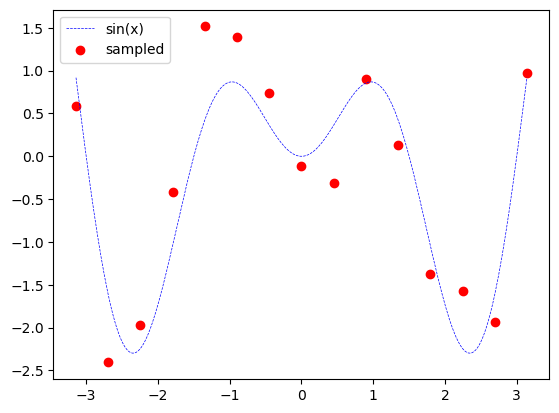

In [14]:
# Function to plot the graph of sin(x) and sample 20 points from the curve with noise
X = np.linspace(-np.pi, np.pi, 256, endpoint=True)
def f(x):
    return np.sin(x*np.pi/1.5) * x
y = f(X)

epsilon = 0.5
number_samples = 15

# Sample 20 points from the curve with noise
X_sample = np.linspace(-np.pi, np.pi, number_samples)
y_sample = f(X_sample) + epsilon * np.random.randn(number_samples)

# Plot the graph
plt.plot(X, y, color="blue", linewidth=0.5, linestyle="--", label="sin(x)")
plt.scatter(X_sample, y_sample, color="red", label="sampled")
plt.legend(loc='upper left')
plt.show()

Curve fitting is one of the most fundamental machine learning tasks. Of which linear regression is the most straight forward. It establishes a relationship between two variables using a linear equation. When predicting one variable based on another, we call the variable we're predicting the dependent variable, and the variable we use for prediction the independent variable.

In this task, we're aiming to predict y (the dependent variable) based on x (the independent variable). The function we're trying to learn is:

$$ 
    y = sin (2 \pi x)
$$

But all we have is a collection of data points sampled from this function with some noise added to it. Our goal is to find a function that best fits the data points. This is called curve fitting.

Objective:

Your goal is to determine the best linear relationship (a straight line) that describes how changes in the independent variable x can predict changes in the dependent variable $y$.

The Linear Equation:

The equation for this line is:
$$ 
    y=wx+b 
$$

where:

- $y$ is the predicted output,
- $x$ is the input feature,
- $w$ is the weight (or slope) of the line, and
- $b$ is the bias (or y-intercept) of the line.

The terms "weight" and "bias" stem from machine learning terminology, but you might have referred to them as the "coefficient" and the "intercept", respectively.

Learning:

"Learning" in the context of linear regression means adjusting values of w and 
b based on the data (i.e., the given $x$ and $y$ values) such that the line (or the "model") predicts the output 
$y$ as accurately as possible for each corresponding input $x$.


When designing a linear regression model, our primary goal is to find a line that best fits the given data points. This "best fit" can be thought of as the line that minimizes the distance (error) between itself and each data point. Specifically, we want to minimize the sum of the squared vertical distances (or residuals) between the data points and the line. Let's consider our line as $y=wx+b$. For each data point $(x_i, y_i)$, the predicted value on the line is $\hat{y}^i ​= wx_i + b$. The residual (difference between observed and predicted values) for this data point is $y_i ​ − \hat{y}^i$. We square these residuals to penalize larger deviations more and sum them up for all data points. We can express this as a function of $w$ and $b$:

$$
\sum_{i=1}^{n} (y_i - \hat{y_i})^2 = \sum_{i=1}^{n} (y_i - (wx_i + b))^2	
$$

Differentiating and setting the derivatives for $w$ and $b$ to zero yields the normal equations:
$$
w = \frac{\sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y})}{\sum_{i=1}^n (x_i - \bar{x})^2}
$$

And:

$$
b = \bar{y} - w\bar{x}
$$

where 
$\bar{x}$
  and 
$\bar{y}$
​
  are the means of $x$ and $y$ values respectively.

---
   **TASK 2.1:** 
Find an expression for the values of $w$ and $b$ using the data provide and plot the resulting function. You can use the numpy library to compute the mean of the $x$ and $y$ values.

Plot the data points and overlay the linear regression line on top of the data.

---



Optimal weight: -0.020081736712425084
Optimal bias: -0.25817749082309355


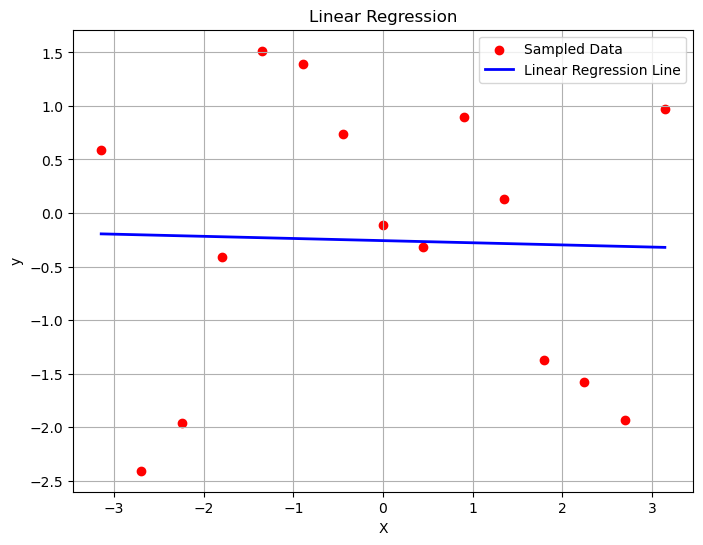

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate the optimal weight and bias terms for linear regression
def linear_regression(X, y):
    x_mean = np.mean(X)
    y_mean = np.mean(y)
    num_samples = len(X)
    
    numerator = np.sum((X - x_mean) * (y - y_mean))
    denominator = np.sum((X - x_mean) ** 2)
    
    weight = numerator / denominator
    bias = y_mean - weight * x_mean
    
    return weight, bias

# Calculate the optimal weight and bias terms for the data X_sample, y_sample
weight, bias = linear_regression(X_sample, y_sample)

# Print the optimal weight and bias
print("Optimal weight:", weight)
print("Optimal bias:", bias)

# Define the linear regression function based on the calculated weight and bias
def linear_regression_function(X, weight, bias):
    return weight * X + bias

# Plot the data points and the linear regression line
plt.figure(figsize=(8, 6))
plt.scatter(X_sample, y_sample, color="red", label="Sampled Data")
plt.plot(X, linear_regression_function(X, weight, bias), color="blue", linewidth=2, label="Linear Regression Line")
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.title('Linear Regression')
plt.grid(True)
plt.show()


Hopefully, through this exercise you can see that while this line does capture the rough trend of the data, it is not a very good fit. This is because the data is not linear. If we want to improve our fit, we can, instead of trying to fit a linear function, try to fit a higher degree polynomial function. Although the target function may not be a polynomial either, we can still use a polynomial to approximate it and because with higher degree polynomials we can get more complex curves, we can get a better fit. Let's try to fit a 2nd degree polynomial (Quadratic) and a 4th degree polynomial (Quartic) to the data.

In general, a polynomial of degree n has the form:
$$
f(x) = a_0 + a_1x + a_2x^2 + a_3x^3 + ... + a_nx^n
$$
where $w_0, w_1, w_2, ..., w_n$ are the coefficients of the polynomial.

We can combine these coefficients into a single weight vector $\mathbf{\hat{w}} = [w_0, w_1, \dots, w_n]^T$ (For the linear polynomial above we would have had $\mathbf{\hat{w}} = [b, w]^T$). 

As a trick to help us in our calculation, we can create the matrix $\mathbf{A} \in \mathbb{R}^{m \times n}$ ($m$ is the # of data points and $n$ is the degree of the fitting polynomial), which is called the Vandermonde matrix. This matrix is defined as: 
$$
\mathbf{A} = \begin{bmatrix} 
1 & x_1 & x_1^2 & \dots & x_1^n \\
1 & x_2 & x_2^2 & \dots & x_2^n \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & x_m & x_m^2 & \dots & x_m^n \\
\end{bmatrix} 
$$

We define $\mathbf{A}$ this way so that we can write the polynomial as a matrix multiplication:
$$
\mathbf{A}\mathbf{\hat{w}} = \begin{bmatrix}
1 & x_1 & x_1^2 & \dots & x_1^n \\
1 & x_2 & x_2^2 & \dots & x_2^n \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & x_m & x_m^2 & \dots & x_m^n \\
\end{bmatrix} \begin{bmatrix}
w_0 \\
w_1 \\
\vdots \\
w_n
\end{bmatrix} = \begin{bmatrix}
w_0 + w_1x_1 + w_2x_1^2 + \dots + w_nx_1^n \\
w_0 + w_1x_2 + w_2x_2^2 + \dots + w_nx_2^n \\
\vdots \\
w_0 + w_1x_m + w_2x_m^2 + \dots + w_nx_m^n \\
\end{bmatrix}
$$

It follows, that the following difference, $\mathbf{A}\mathbf{\hat{w}} - \mathbf{y}$ has the property the entry $i$ of this vector is the signed difference between the predicted and true value for the $i$'th data point. Our goal is to minimize the squared error of this, or, $E(\mathbf{\hat{w}}) = \| \mathbf{A}\mathbf{\hat{w}} - \mathbf{y} \|^2 $. 

Expanding this out, we get:

$$ 
    E(\mathbf{\hat{w}}) = (\mathbf{A}\mathbf{\hat{w}} - \mathbf{y})^T (\mathbf{A}\mathbf{\hat{w}} - \mathbf{y}) 
$$

To minimize this error, we'll set its gradient with respect to $\left( \mathbf{w} \right)$ to zero:


$$ 
\nabla E(\mathbf{w}) = \nabla (\mathbf{A}\mathbf{w} - \mathbf{y})^T (\mathbf{A}\mathbf{w} - \mathbf{y}) = 2\mathbf{A}^T\mathbf{A}\mathbf{w} - 2\mathbf{A}^T\mathbf{y} = 0
$$


So we have, 
$$
    2\mathbf{A}^T\mathbf{A}\mathbf{w} - 2\mathbf{A}^T\mathbf{y} = 0
$$

---
   **TASK 2.2:** 

Your task is to write a function `calculate_weights`, which takes in
- An $m$ dimensional vector of data points $X$
- An $m$ dimensional vector of corresponding values $y$ obtained by sampling from a noisy function
- An integer $n$ representing the degree of the polynomial to fit to the data

and returns the weight vector $\mathbf{\hat{w}}$ that minimizes the squared error.

---

**Hint**: You can use `np.linalg.inv` to invert a matrix.


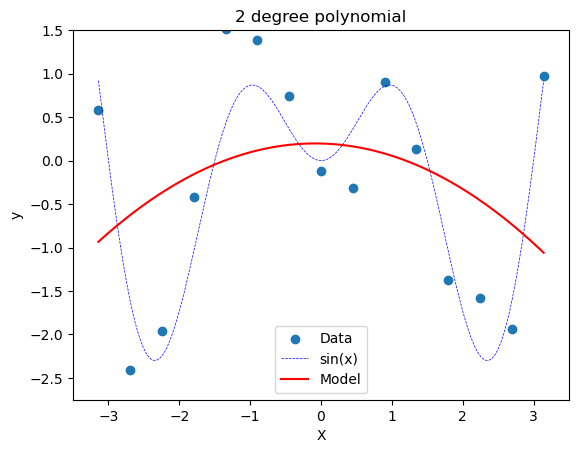

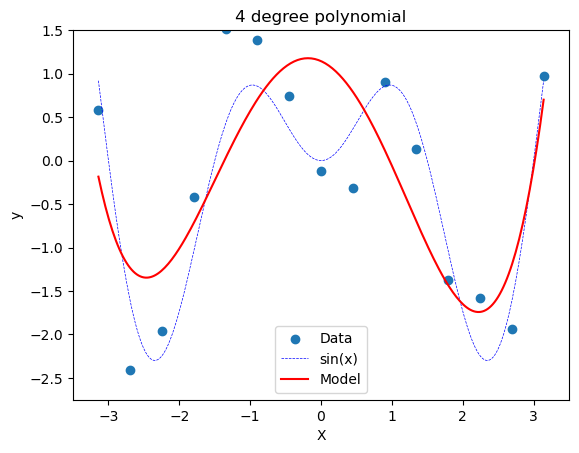

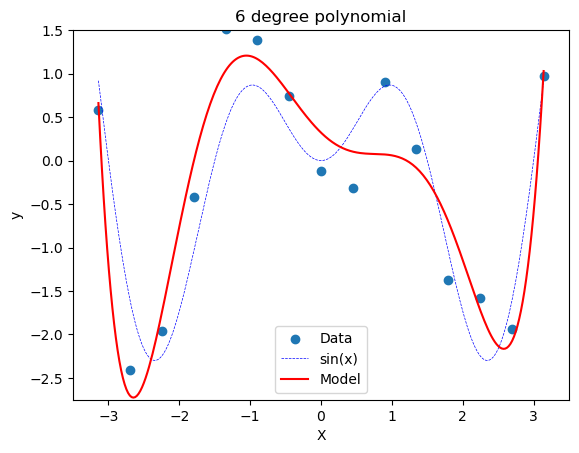

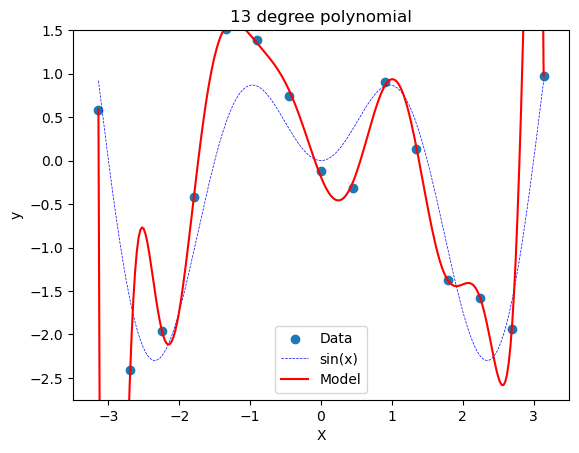

In [16]:
def calculate_weights(X, y, n):
    A = np.array([X**i for i in range(n+1)]).T
    w = np.linalg.inv(A.T @ A) @ A.T @ y
    return w

def poly_vector(x, n):
    return np.array([x ** i for i in range(n+1)])

def plot_poly_fit(X_sample, y_sample, w):
    n = len(w) - 1  # degree of polynomial

    # Plot the data and the polynomial fit
    plt.title(f'{n} degree polynomial')
    plt.scatter(X_sample, y_sample, label='Data')
    plt.plot(X, y, color="blue", linewidth=0.5, linestyle="--", label="sin(x)")
    plt.plot(X, w @ poly_vector(X, n), 'r', label='Model')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.xlim(-3.5, 3.5)
    plt.ylim(-2.75, 1.5)
    plt.legend()
    plt.show()

# Test for quadratic polynomial
w = calculate_weights(X_sample, y_sample, 2)
plot_poly_fit(X_sample, y_sample, w)

# Test for quartic polynomial
w = calculate_weights(X_sample, y_sample, 4)
plot_poly_fit(X_sample, y_sample, w)

# Test for 6th degree polynomial
w = calculate_weights(X_sample, y_sample, 6)
plot_poly_fit(X_sample, y_sample, w)

# Test for 13th degree polynomial
w = calculate_weights(X_sample, y_sample, 13)
plot_poly_fit(X_sample, y_sample, w)


We can see that initially, as we increase the degree of the polynomial, we get a better fit to the data. However, as we continue to increase the polynomial degree even further, the model not only fits the training data but also starts capturing the noise in the data. This phenomenon can be understood better using the concept of the bias-variance trade-off.

- Bias: Bias refers to the error due to overly simplistic assumptions in the learning algorithm. In our context, using a low-degree polynomial might be too simple to capture the underlying structure of the data. Such a model will have high bias because it assumes the data can be represented by a simple curve, even when it cannot. As a result, it systematically misrepresents the data, leading to consistent and high error on both the training and test datasets.

- Variance: Variance refers to the error due to too much complexity in the learning algorithm. With a high-degree polynomial, our model becomes extremely flexible. Such flexibility allows the model to fit the training data very closely, including its noise and fluctuations. However, this results in a model with high variance, as even slight changes in the training data can lead to significantly different models. These models perform well on the training data but fail to generalize to new, unseen data, leading to high error on the test dataset.

- Bias-Variance Trade-off: Increasing the degree decreases bias since the model becomes more flexible and can fit the training data better.
However, past a certain point, increasing the degree also increases variance since the model begins to fit the noise in the training data.
The bias-variance trade-off is the balance between these two sources of error. Ideally, we want to find the right level of model complexity that captures the underlying structure of the data but doesn't get swayed by its noise. 


If we sample another set of points from the same distribution, which we will call the test set, we can get a better picture of how well our model generalizes to unseen data. We can visualize the training and test set together to compare them.


---
   **TASK 2.3:** 

Write an error function `polynomial_regression_error` which computes the mean squared error between the predicted outputs and the true outputs for any input data. Then use this function to find the training and test errors for each of the models we have trained so far. Plot these errors as a function of the degree of the polynomial.

---




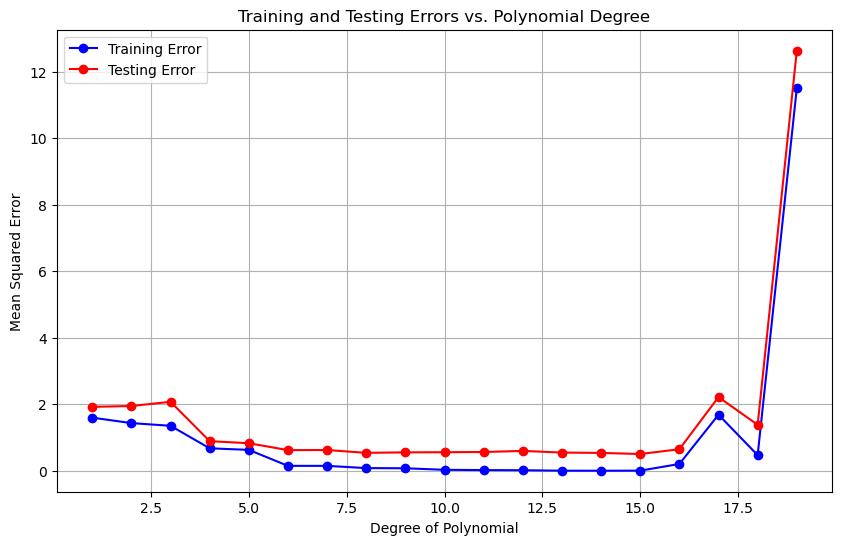

In [17]:
number_testing_points = 15

# Sample points from the curve with noise for testing
X_sample_testing = np.linspace(-np.pi, np.pi, number_testing_points)
y_sample_testing = f(X_sample_testing) + epsilon * np.random.randn(number_testing_points)

# Function to calculate mean squared error
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Function to calculate polynomial regression error
def polynomial_regression_error(X_training_values, y_training_values, X_testing_values, y_testing_values, n):
    A_training = np.array([X_training_values**i for i in range(n+1)]).T
    A_testing = np.array([X_testing_values**i for i in range(n+1)]).T

    # Calculate weights for training data
    w = np.linalg.inv(A_training.T @ A_training) @ A_training.T @ y_training_values

    # Predictions for training and testing data
    y_predicted_training_error = A_training @ w
    y_predicted_testing_error = A_testing @ w

    # Calculate mean squared errors
    training_error = mean_squared_error(y_training_values, y_predicted_training_error)
    testing_error = mean_squared_error(y_testing_values, y_predicted_testing_error)

    return training_error, testing_error

# Initialize lists to store training and testing errors
training_error = []
testing_error = []

# Calculate errors for different polynomial degrees
for n in range(1, 20):
    y_predicted_training_error, y_predicted_testing_error = polynomial_regression_error(X_sample, y_sample, X_sample_testing, y_sample_testing, n)
    training_error.append(y_predicted_training_error)
    testing_error.append(y_predicted_testing_error)

# Plot the training and testing errors
plt.figure(figsize=(10, 6))
plt.plot(range(1, 20), training_error, marker='o', label='Training Error', color='blue')
plt.plot(range(1, 20), testing_error, marker='o', label='Testing Error', color='red')
plt.xlabel('Degree of Polynomial')
plt.ylabel('Mean Squared Error')
plt.title('Training and Testing Errors vs. Polynomial Degree')
plt.legend()
plt.grid(True)
plt.show()


We can now see clearly that as the degree of the polynomial increases, the model fits the training data better and better. However, the model also becomes more complex, and starts to fit the noise in the data as well. The result is that the model starts to overfit the data, and will actually perform worse on the unseen test data. This is a classic example of the bias-variance tradeoff in machine learning and is not unique to polynomial regression.

**How do we overcome overfitting?**

This is where regularization comes into play. Regularization techniques add a penalty to the cost function to constrain or shrink the model parameters, discouraging overly complex models which can overfit the training data. By adding this penalty, regularization ensures that the model remains somewhat simpler, even if we are using a high-degree polynomial or a complicated neural network. There are different forms of regularization, but the most common are L1 regularization (which tends to produce sparse weight vectors) and L2 regularization (which tends to produce smaller weight vectors). In polynomial regression, L2 regularization (also known as Ridge regression) is commonly used.


So what does this mean for our polynomial regression model? We can add a regularization term to the cost function:
$$
    E(\mathbf{w}) = \| \mathbf{A}\mathbf{w} - \mathbf{y} \|^2 + \lambda \| \mathbf{w} \|^2
$$

Differentiating this with respect to $\left( \mathbf{w} \right)$ gives:
$$
    \nabla E(\mathbf{w}) = 2\mathbf{A}^T\mathbf{A}\mathbf{w} - 2\mathbf{A}^T\mathbf{y} + 2\lambda\mathbf{w}
$$

We can see that with greater $\lambda$, the model will be penalized more for having large weights. This will encourage the model to be simpler, and will reduce overfitting. 

---
   **TASK 2.4:** 
Your task is to implement polynomial regression with L2 regularization. To do this you will need to write a function `calculate_weights_regularized` that takes in the training data, the test data, the degree of the polynomial, and the regularization parameter $\lambda$, and returns the polynomial coefficients $\mathbf{w}$.

---

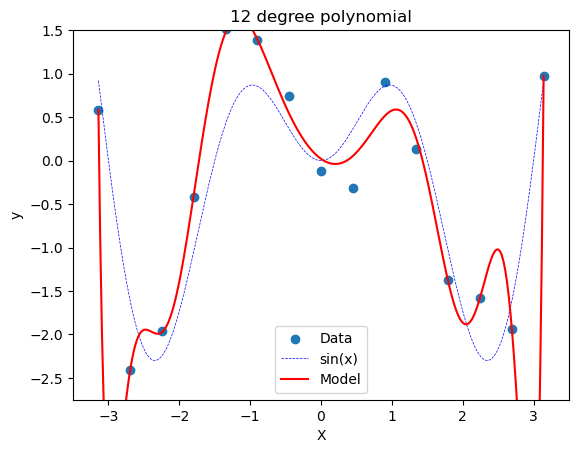

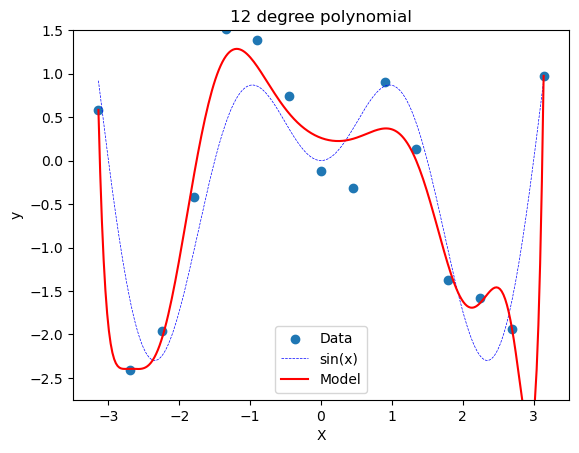

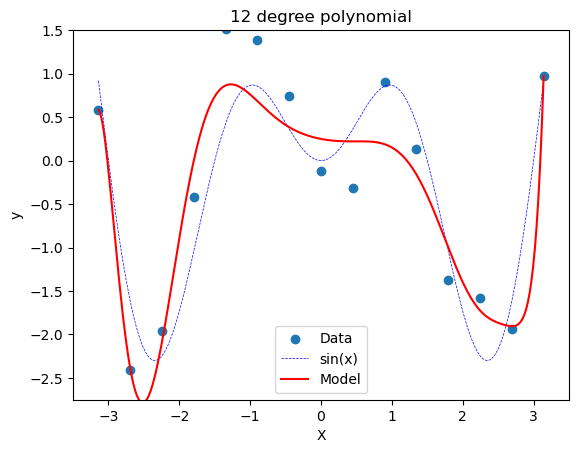

In [18]:
def calculate_weights_regularized(X_sample, y_sample, n, lam):
    A = np.array([X_sample**i for i in range(n+1)]).T
    I = np.identity(n+1)
    w = np.linalg.inv(A.T @ A + lam * I) @ A.T @ y_sample
    return w

# Test for 12-degree polynomial, and lambda = 0.1
w = calculate_weights_regularized(X_sample, y_sample, 12, 0.1)
plot_poly_fit(X_sample, y_sample, w)

# Test for 12-degree polynomial, and lambda = 1
w = calculate_weights_regularized(X_sample, y_sample, 12, 1)
plot_poly_fit(X_sample, y_sample, w)

# Test for 12-degree polynomial, and lambda = 5
w = calculate_weights_regularized(X_sample, y_sample, 12, 5)
plot_poly_fit(X_sample, y_sample, w)



---
   **TASK 2.5:** 
We can see that with a larger regularization paramater $\lambda$ we get a smoother fit as the coefficients are penalized more for being large. Write a function `polynomial_regression_error_regularized` that computes the training and test error as a function of $\lambda$ and plot the result for a 12 degree polynomial fit to see how the regularization parameter affects the generalizability of the model.
___

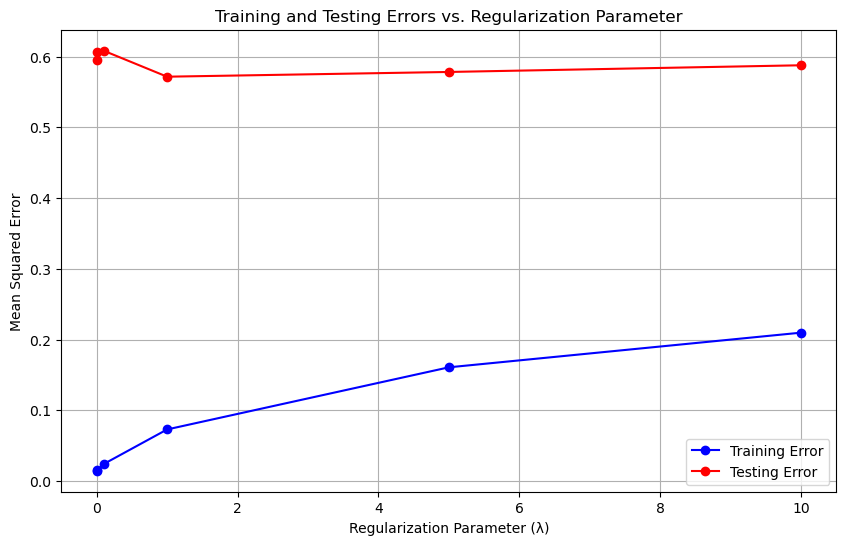

In [19]:
def polynomial_regression_error_regularized(X_training_values, y_training_values, X_testing_values, y_testing_values, n, lam):
    A_training = np.array([X_training_values**i for i in range(n+1)]).T
    A_testing = np.array([X_testing_values**i for i in range(n+1)]).T

    # Calculate weights for training data with L2 regularization
    I = np.identity(n+1)
    w = np.linalg.inv(A_training.T @ A_training + lam * I) @ A_training.T @ y_training_values

    # Predictions for training and testing data
    y_predicted_training_error = A_training @ w
    y_predicted_testing_error = A_testing @ w

    # Calculate mean squared errors
    training_error = mean_squared_error(y_training_values, y_predicted_training_error)
    testing_error = mean_squared_error(y_testing_values, y_predicted_testing_error)

    return training_error, testing_error

# Initialize lists to store training and testing errors
training_error = []
testing_error = []
lam_values = [0, 0.01, 0.1, 1, 5, 10]

# Calculate errors for different regularization parameters
for lam in lam_values:
    y_predicted_training_error, y_predicted_testing_error = polynomial_regression_error_regularized(X_sample, y_sample, X_sample_testing, y_sample_testing, 12, lam)
    training_error.append(y_predicted_training_error)
    testing_error.append(y_predicted_testing_error)

# Plot the training and testing errors as a function of lambda
plt.figure(figsize=(10, 6))
plt.plot(lam_values, training_error, marker='o', label='Training Error', color='blue')
plt.plot(lam_values, testing_error, marker='o', label='Testing Error', color='red')
plt.xlabel('Regularization Parameter (λ)')
plt.ylabel('Mean Squared Error')
plt.title('Training and Testing Errors vs. Regularization Parameter')
plt.legend()
plt.grid(True)
plt.show()


We see that with larger values for the regularization paramater $\lambda$, the testing error decreases while the training error increases. This is because the model is overfitting the training data, and the regularization term is penalizing the model for having large coefficients. 
